Nama : Fachri Najm Noer Kartiman <br>
NIM : 2106515 <br>
UAS DATA MINING

In [382]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import joblib
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

IPM (Indeks Pembangunan Manusia) adalah ukuran kualitas sumber daya manusia. PMI memiliki tiga dimensi: <br>(1) umur panjang dan hidup sehat (a long and healthy life), <br>(2) pengetahuan (knowledge), dan <br>(3) standar hidup layak (decent standard of living).  PMI dihitung menggunakan data harapan hidup, rata-rata lama sekolah, pengeluaran per kapita.

# PRAPROSES

## import dataset

dengan adanya tiga dimensi dari indeks pembangunan manusia maka diputuskan saya mengimport 5 dataset ini: <br>

In [383]:
# hidup sehat
dfPangan = pd.read_csv("C:\\Users\\Fachri Najm\\Data Mining\\UAS\\data\\ketidak_cukupan_pangan_prov.csv")
# pengetahuan
dfMelek = pd.read_csv("C:\\Users\\Fachri Najm\\Data Mining\\UAS\\data\\melek_huruf_diatas15.csv")
# dataset yang perlu diprediksi
dfPMI = pd.read_csv("C:\\Users\\Fachri Najm\\Data Mining\\UAS\\data\\pmi.csv")
# standar hidup layak
dfNikah = pd.read_csv("C:\\Users\\Fachri Najm\\Data Mining\\UAS\\data\\proporsi_perempuan_18_24_nikah_prov.csv")
# hidup sehat
dfKesehatan = pd.read_csv("C:\\Users\\Fachri Najm\\Data Mining\\UAS\\data\\persen_unmet_need_pelayanan_kesehatan.csv")
# standar hidup layak
dflayanan = pd.read_csv("C:\\Users\\Fachri Najm\\Data Mining\\UAS\\data\\proporsi_rt_akses_layanan_dasar.csv")

In [384]:
# Merge data ketidak cukuoan pangan dna melek huruf diatas 15 tahun
df = pd.merge(dfPMI, dfMelek,how = 'left', on = ['prov', 'tahun'])
df = pd.merge(df, dfPangan,how = 'left', on = ['prov', 'tahun'])
df = pd.merge(df, dfNikah,how = 'left', on = ['prov', 'tahun'])
df = pd.merge(df, dfKesehatan,how = 'left', on = ['prov', 'tahun'])
df = pd.merge(df, dflayanan,how = 'left', on = ['prov', 'tahun'])
# mengecek ada berapa provinsi 'indonesia'
len(df[df['prov'] == 'INDONESIA'])

0

In [385]:
len(df['tahun'].unique())

13

In [386]:
len(df['prov'].unique())

34

In [387]:
len(df['prov'].unique())

34

In [388]:
df

,prov,tahun,kategori_pmi,melek_huruf_diatas15,pct_tdk_cukup_pangan,pct_perempuan_nikah,persen_unmet_need_pelayanan_kesehatan,proporsi_rt_akses_layanan_dasar
0,ACEH,2022,TINGGI,98.25,NaN,NaN,6.83,NaN
1,SUMATERA UTARA,2022,TINGGI,99.11,NaN,NaN,5.96,NaN
2,SUMATERA BARAT,2022,TINGGI,99.29,NaN,NaN,4.31,NaN
3,RIAU,2022,TINGGI,99.18,NaN,NaN,5.82,NaN
4,JAMBI,2022,TINGGI,98.1,NaN,NaN,6.56,NaN
...,...,...,...,...,...,...,...,...
437,SULAWESI BARAT,2010,SANGAT RENDAH,NaN,NaN,NaN,NaN,NaN
438,MALUKU,2010,SEDANG,NaN,NaN,NaN,NaN,NaN
439,MALUKU UTARA,2010,SEDANG,NaN,NaN,NaN,NaN,NaN
440,PAPUA BARAT,2010,SANGAT RENDAH,NaN,NaN,NaN,NaN,NaN


In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 0 to 441
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   prov                                   442 non-null    object 
 1   tahun                                  442 non-null    int64  
 2   kategori_pmi                           442 non-null    object 
 3   melek_huruf_diatas15                   306 non-null    object 
 4   pct_tdk_cukup_pangan                   170 non-null    float64
 5   pct_perempuan_nikah                    238 non-null    float64
 6   persen_unmet_need_pelayanan_kesehatan  272 non-null    float64
 7   proporsi_rt_akses_layanan_dasar        102 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 31.1+ KB


In [390]:
df[['prov', 'kategori_pmi', 'tahun']] = df[['prov', 'kategori_pmi','tahun']].astype('category')
df['melek_huruf_diatas15'] = pd.to_numeric(df['melek_huruf_diatas15'], errors='coerce')

In [391]:
df.describe()

,melek_huruf_diatas15,pct_tdk_cukup_pangan,pct_perempuan_nikah,persen_unmet_need_pelayanan_kesehatan,proporsi_rt_akses_layanan_dasar
count,305.000000,170.000000,238.000000,272.000000,102.000000
mean,96.014787,10.813706,27.543992,5.142206,77.222255
std,4.668504,8.447757,6.812265,1.646468,10.079431
min,70.780000,1.430000,10.250000,1.560000,35.550000
25%,94.100000,5.982500,23.205000,3.952500,73.927500
50%,97.900000,8.845000,27.135000,4.825000,79.110000
75%,98.770000,11.477500,31.852500,6.207500,83.330000
max,99.870000,38.350000,50.430000,10.210000,91.300000


Melihat apakah data NULL di dataset

In [392]:
df.isnull().sum()

prov                                       0
tahun                                      0
kategori_pmi                               0
melek_huruf_diatas15                     137
pct_tdk_cukup_pangan                     272
pct_perempuan_nikah                      204
persen_unmet_need_pelayanan_kesehatan    170
proporsi_rt_akses_layanan_dasar          340
dtype: int64

mengisi data NULL dengan rata - rata tiap provinsi

In [393]:
df['melek_huruf_diatas15'] = df.groupby(['prov'])['melek_huruf_diatas15'].transform('mean')
df['pct_tdk_cukup_pangan'] = df.groupby(['prov'])['pct_tdk_cukup_pangan'].transform('mean')
df['pct_perempuan_nikah'] = df.groupby(['prov'])['pct_perempuan_nikah'].transform('mean')
df['persen_unmet_need_pelayanan_kesehatan'] = df.groupby(['prov'])['persen_unmet_need_pelayanan_kesehatan'].transform('mean')
df['proporsi_rt_akses_layanan_dasar'] = df.groupby(['prov'])['proporsi_rt_akses_layanan_dasar'].transform('mean')

In [394]:
df

,prov,tahun,kategori_pmi,melek_huruf_diatas15,pct_tdk_cukup_pangan,pct_perempuan_nikah,persen_unmet_need_pelayanan_kesehatan,proporsi_rt_akses_layanan_dasar
0,ACEH,2022,TINGGI,97.967778,8.394,23.478571,4.23875,67.096667
1,SUMATERA UTARA,2022,TINGGI,98.966667,6.208,28.145714,4.17375,68.983333
2,SUMATERA BARAT,2022,TINGGI,98.957778,5.552,33.188571,3.64875,81.193333
3,RIAU,2022,TINGGI,99.097778,9.272,26.217143,5.17250,73.363333
4,JAMBI,2022,TINGGI,98.047778,9.662,25.830000,4.74625,72.666667
...,...,...,...,...,...,...,...,...
437,SULAWESI BARAT,2010,SANGAT RENDAH,92.996667,9.516,30.260000,6.84375,78.846667
438,MALUKU,2010,SEDANG,99.171111,32.006,32.210000,5.04875,78.190000
439,MALUKU UTARA,2010,SEDANG,98.667778,32.990,27.794286,4.83250,78.180000
440,PAPUA BARAT,2010,SANGAT RENDAH,97.333333,23.060,25.160000,4.02000,72.236667


# EDA

relasi antar atribut

C:\Temp\ipykernel_10668\2511265636.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, vmin=0, vmax=1, cmap='plasma')


<AxesSubplot: >

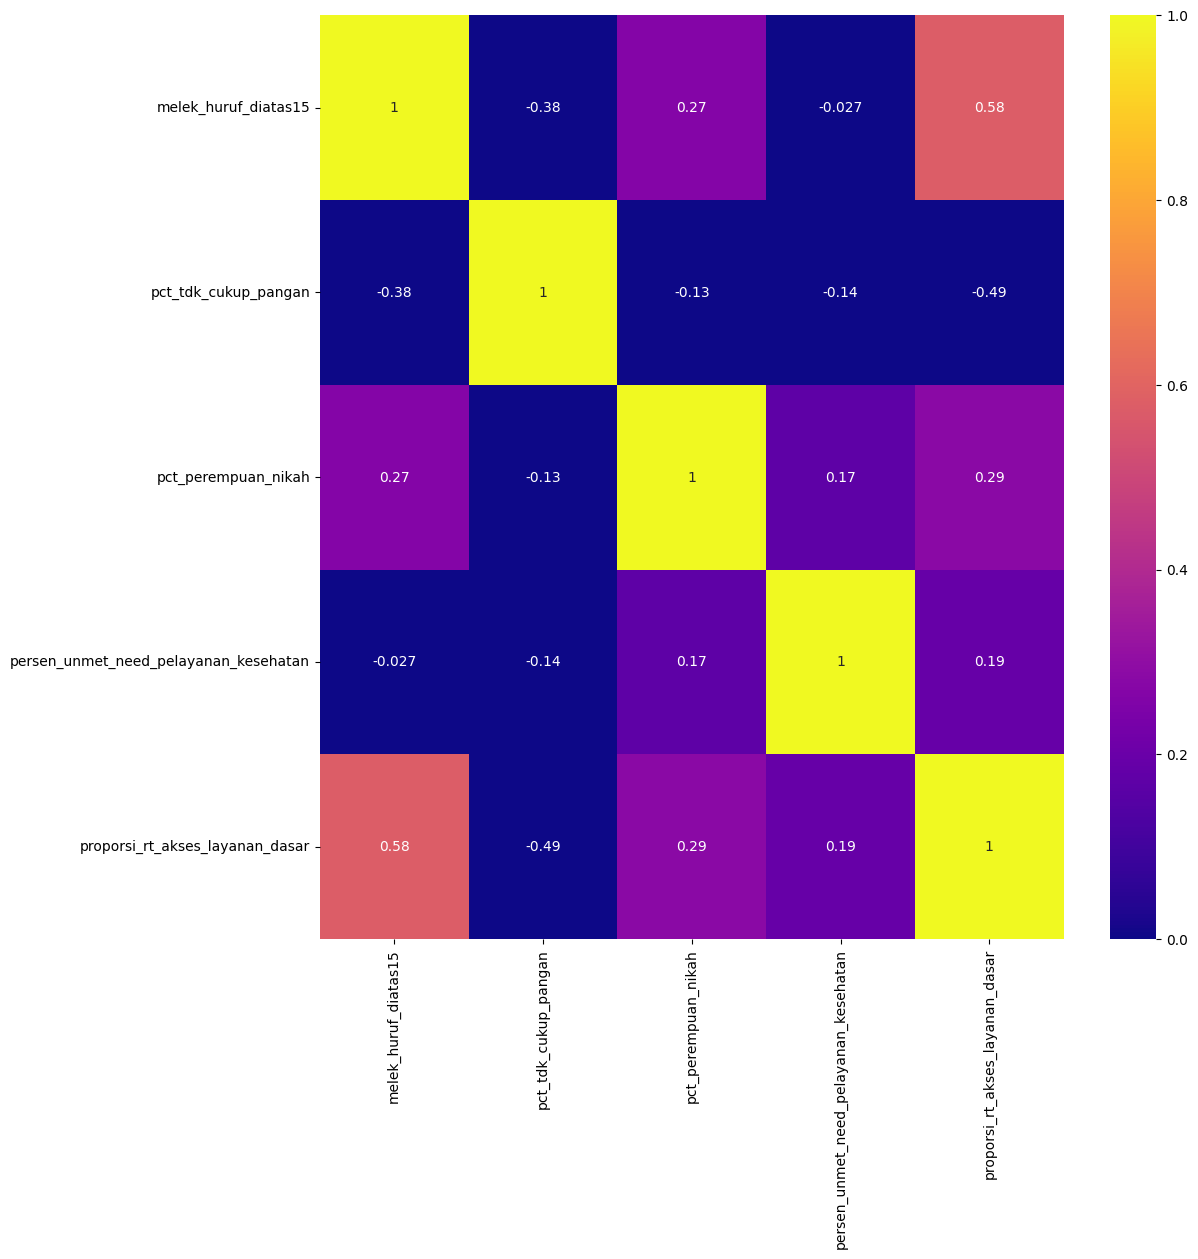

In [395]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, vmin=0, vmax=1, cmap='plasma')

membuat group berdasarkan kategori_pmi

In [396]:
grouped = df.groupby(by='kategori_pmi').mean().reset_index()
grouped

C:\Temp\ipykernel_10668\1619729414.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df.groupby(by='kategori_pmi').mean().reset_index()


,kategori_pmi,melek_huruf_diatas15,pct_tdk_cukup_pangan,pct_perempuan_nikah,persen_unmet_need_pelayanan_kesehatan,proporsi_rt_akses_layanan_dasar
0,SANGAT RENDAH,84.792120,26.141733,22.973714,3.931500,55.083778
1,SANGAT TINGGI,98.456944,3.573000,30.417857,3.411250,78.471667
2,SEDANG,95.801456,12.564635,27.732817,5.639091,76.626359
3,TINGGI,97.202087,7.237376,27.535437,4.602699,79.989667


Membandingkan nilai rata tiap column dengan kategori_PMI

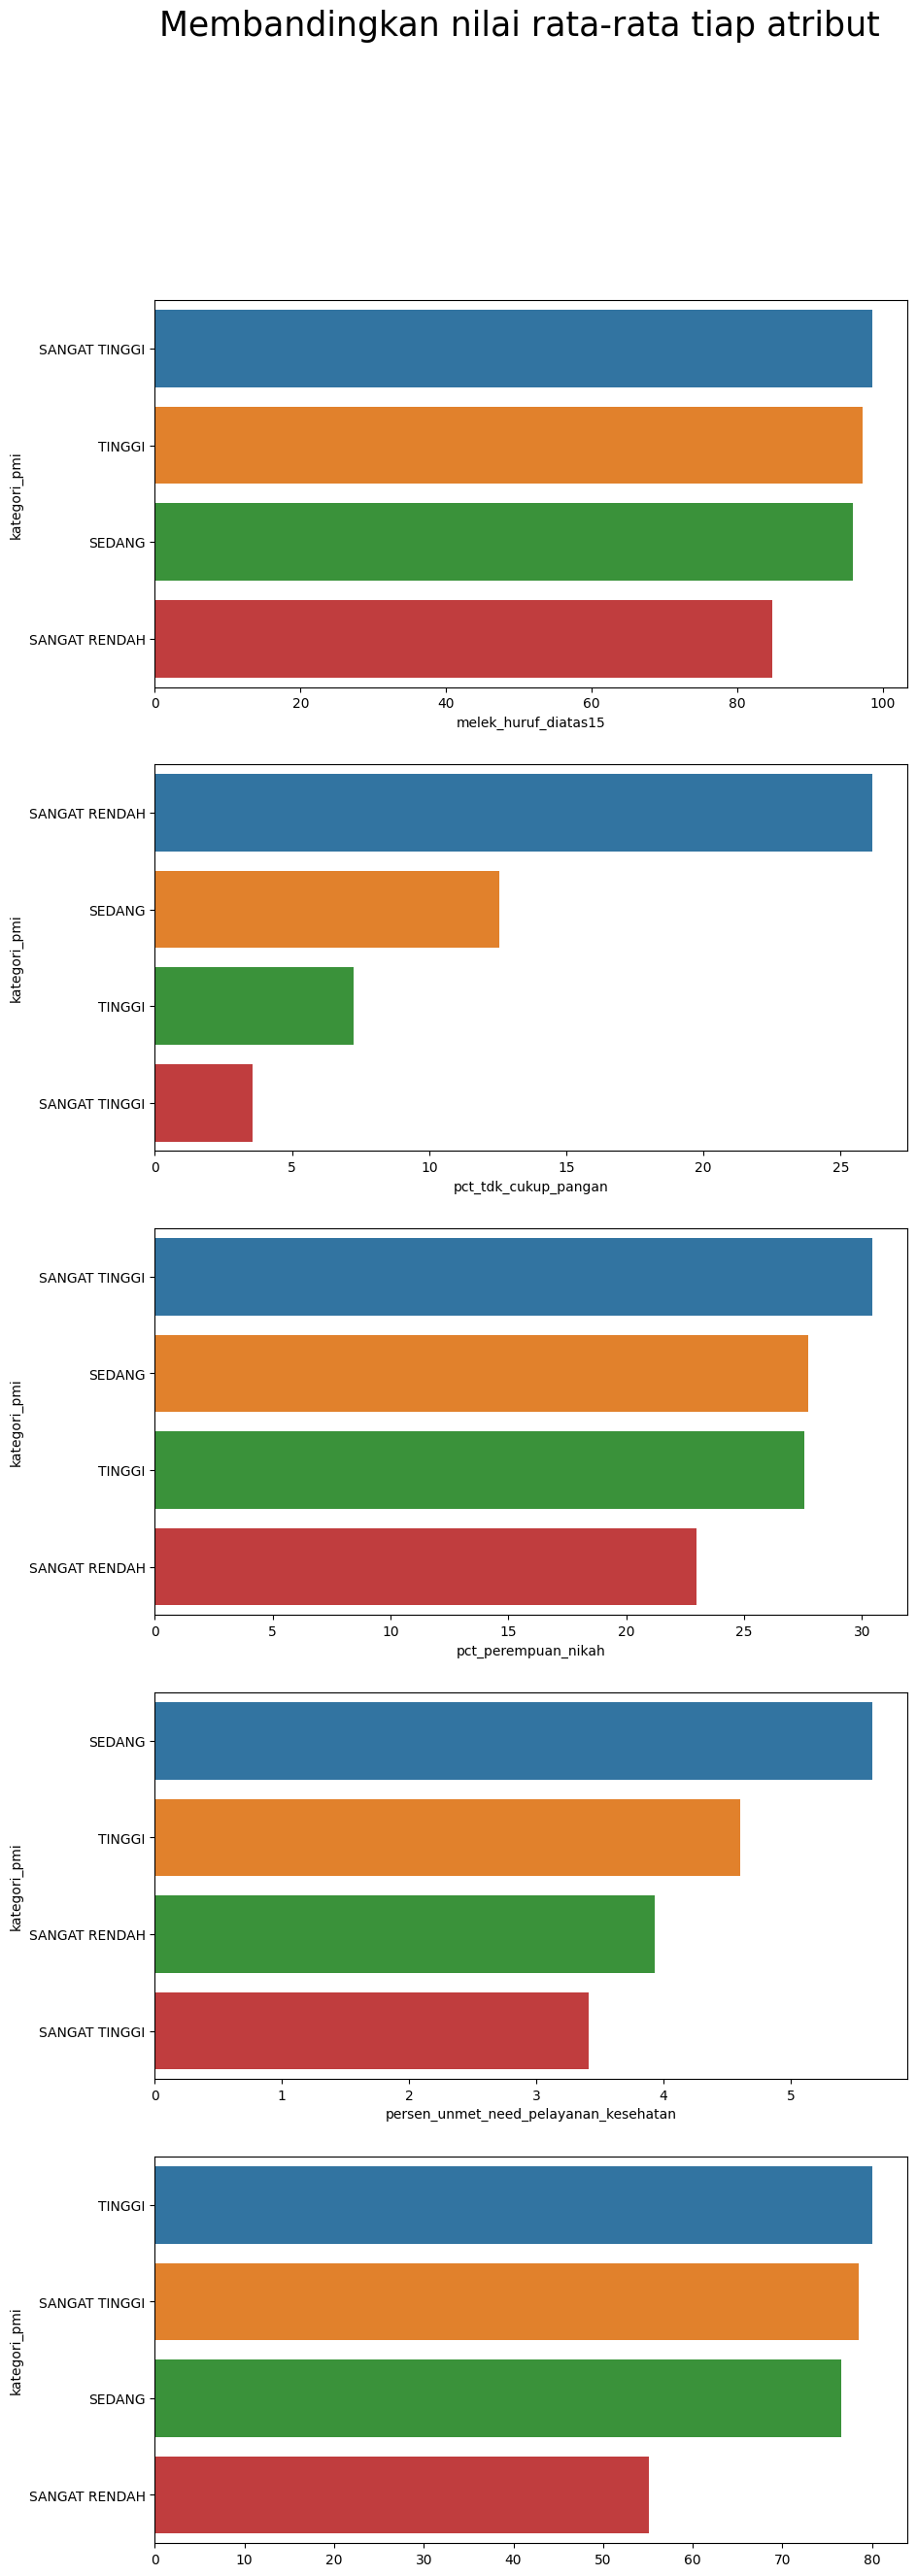

In [397]:
fig,ax=plt.subplots(5,1,figsize=(10,30))
for index,i in enumerate(grouped.columns[1:]):
    sns.barplot(data=grouped,y='kategori_pmi', x=i, ax=ax[index], 
                order=grouped.sort_values(i, ascending = False).kategori_pmi)
    plt.suptitle("Membandingkan nilai rata-rata tiap atribut", size=25)
    plt.xlabel("")
plt.show()

dapat dilihat dari plot diatas bahwa <br>
1. melek huruf diatas 15 tahun kategori PMI nya menyebarlebih dari 80% <br>
2. banyak orang yang tidak cukup pangan dengan kategori PMI sangat rendah <br>
3. lebih dari 20% peremmpuan yang sudah menikkah dengan kondisi PMI yang hampir sama<br>
5. dengan meningkat nya akses kela yanan daasar menigkat pula kategori PMI nya<br>

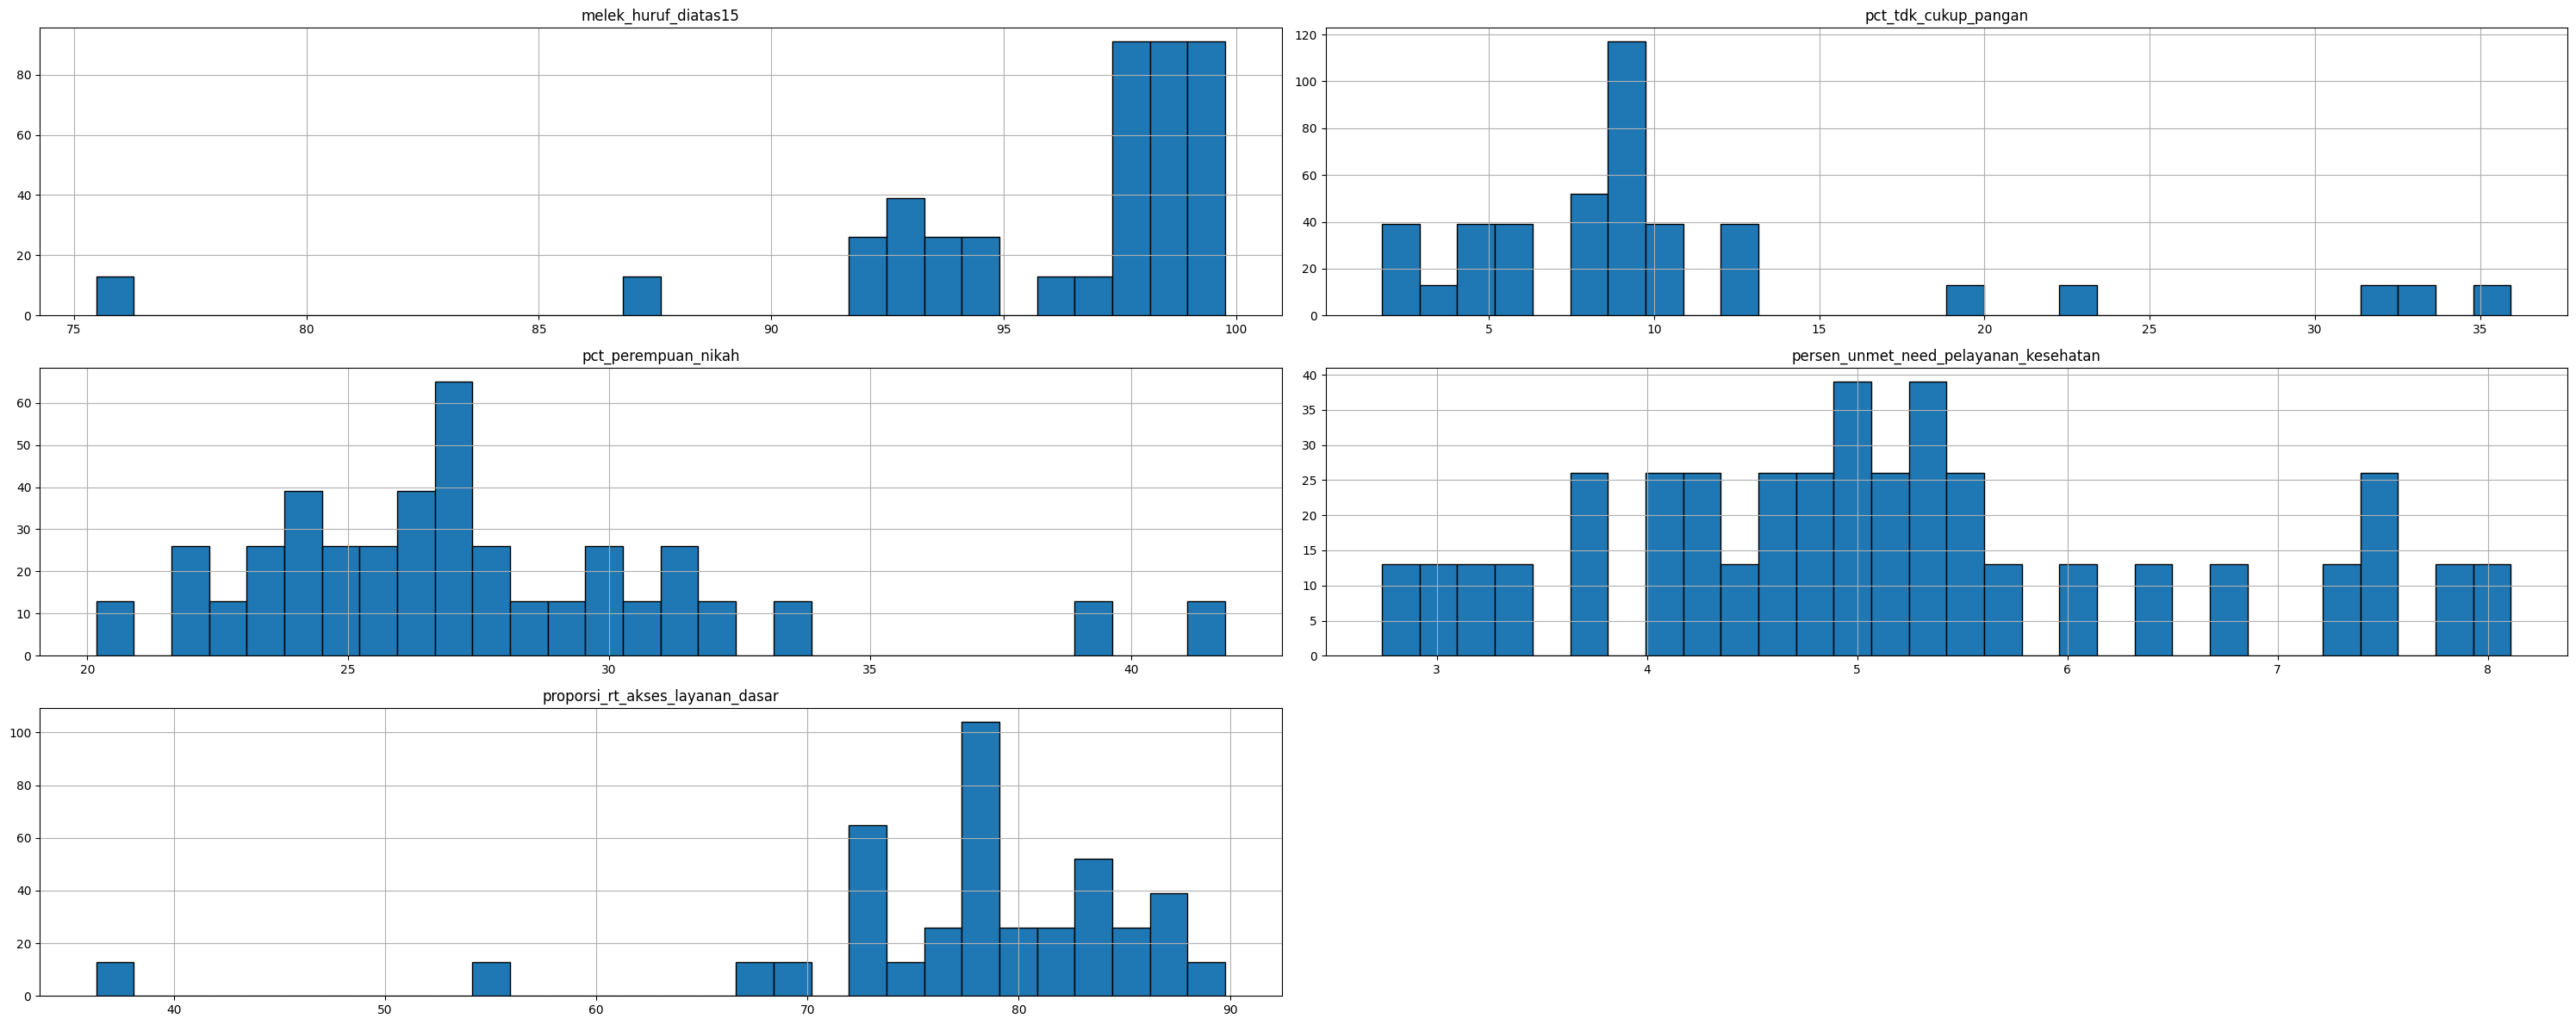

In [398]:
df.hist(figsize=(30,12), bins=30, ec='black')
plt.tight_layout()

menampilkan keseluruhan persen 5 atribut yang ternyata ada yang menarik:
1. hampir semua melek huruf<br>
2. 50% dari keseluruhan masih kekurangan pangan<br>
3. perempuan dibawah 50% yang belum nikah dibawah 18 tahun<br>

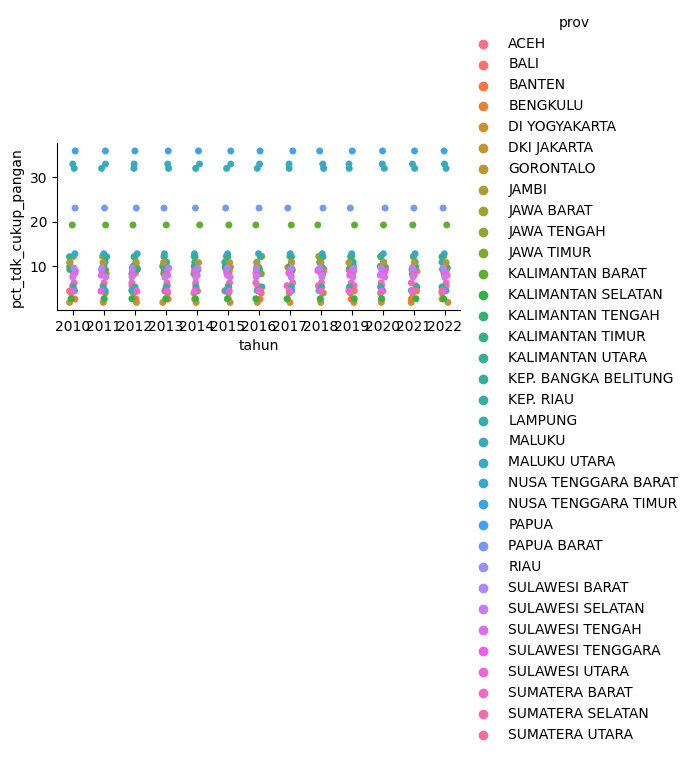

In [399]:
sns.catplot(y = "pct_tdk_cukup_pangan", x = "tahun", hue = "prov", data = df)

dari plot diatas disimpulkan kalo tiap tahun bahkan kekurangan pangan belum teratasi dengan baik

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 0 to 441
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   prov                                   442 non-null    category
 1   tahun                                  442 non-null    category
 2   kategori_pmi                           442 non-null    category
 3   melek_huruf_diatas15                   442 non-null    float64 
 4   pct_tdk_cukup_pangan                   442 non-null    float64 
 5   pct_perempuan_nikah                    442 non-null    float64 
 6   persen_unmet_need_pelayanan_kesehatan  442 non-null    float64 
 7   proporsi_rt_akses_layanan_dasar        442 non-null    float64 
dtypes: category(3), float64(5)
memory usage: 24.2 KB


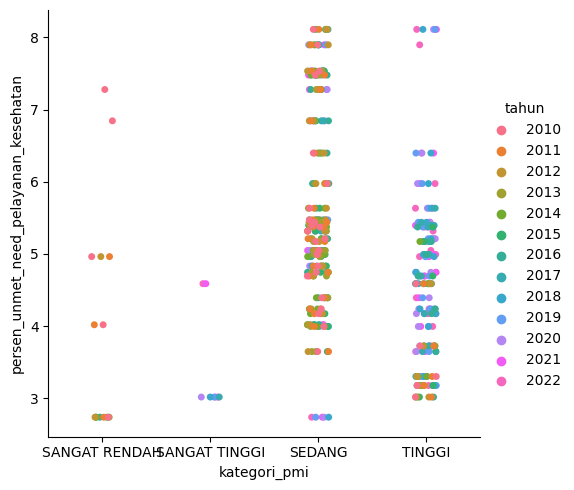

In [401]:
sns.catplot(y = "persen_unmet_need_pelayanan_kesehatan", x = "kategori_pmi", hue = "tahun", data = df)

yang menarik ada di outer di sebelah kiri ternyata walaupun persen mendapatkan pelayaan kesehatan tinggi tapi masih tergolong sangat rendah

# TRAINING DATA

One hot encoding data dengan tipe categori

In [402]:
dfHot = pd.get_dummies(data=df, columns=['prov', 'tahun'])

Label encoding data yang akan diprediksi

In [403]:
target = preprocessing.LabelEncoder()
target.fit(dfHot.kategori_pmi)
Y = target.transform(dfHot.kategori_pmi)

Drop kategori_PMI dan masukkan ke X

In [404]:
X = dfHot.drop("kategori_pmi",axis=1)

split data menjadi data train dan data test

In [405]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=123)
with open('xTrainColumn.pickle', 'wb') as fp:
    pickle.dump(X_train.columns, fp)


## Random Forest Classification

In [406]:
clf = RandomForestClassifier(n_estimators=200, random_state=12, max_depth = 20)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print("Akurasi {}".format(acc))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Akurasi 0.797752808988764
[[ 1  0  1  0]
 [ 0  0  0  1]
 [ 2  0 48  4]
 [ 0  2  8 22]]
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.00      0.00      0.00         1
           2       0.84      0.89      0.86        54
           3       0.81      0.69      0.75        32

    accuracy                           0.80        89
   macro avg       0.50      0.52      0.50        89
weighted avg       0.81      0.80      0.80        89



## XGboost Classification

In [407]:
clf = xgb.XGBClassifier(objective = "multi:softprob", num_class = 2, eval_metric = "mlogloss", max_depth = 24, gamma=0.1, subsample = 0.90,learning_rate=0.01, n_estimators = 10, nthread=-1)
# num_class adalah jumlah kelas
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
print("Akurasi {}".format(acc))
print(classification_report(Y_test, Y_pred))

Akurasi 0.797752808988764
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.00      0.00      0.00         1
           2       0.86      0.89      0.87        54
           3       0.81      0.69      0.75        32

    accuracy                           0.80        89
   macro avg       0.50      0.52      0.50        89
weighted avg       0.82      0.80      0.81        89



## Feature importance

In [408]:
feature_importances = pd.DataFrame({
    'attr' : X_train.columns, 
    'importance' :clf.feature_importances_
}).sort_values('importance',ascending=False)
# pd.set_option('display.max_rows', None)
feature_importances

,attr,importance
1,pct_tdk_cukup_pangan,0.084571
3,persen_unmet_need_pelayanan_kesehatan,0.081504
42,tahun_2013,0.062483
43,tahun_2014,0.057533
41,tahun_2012,0.057007
40,tahun_2011,0.052171
47,tahun_2018,0.051052
19,prov_KALIMANTAN TIMUR,0.046498
48,tahun_2019,0.043984
49,tahun_2020,0.040634
